# RoboJackets Controls Training
**If you are viewing this on GitHub and do not wish to run Jupyter locally, click [here](https://colab.research.google.com/github/kylestach/rj-controls-training/blob/master/Controls_Training_Chapter_1.ipynb) to open it in Google Colab.**
## Preface
Welcome to RoboJackets controls training. Through these self-guided resources, you will learn how to implement _control systems_ for robots, with a focus on the type of wheeled mobile robots we have on RoboJackets' autonomous teams:

 - RoboCup
 - IGVC
 - RoboRacing
 - RoboWrestling

This course will focus on the practical aspects of controls. That said, control theory is a heavily mathematical discipline and a lot of the material in this course is no exception. We recommend a strong background in calculus in one and multiple variables, linear algebra, and the principles of differential equations. If any of the following is unfamiliar to you, we would recommend brushing up on your knowledge:
 - Calculus (integrals and derivatives)
    - Basic functions (polynomial, exponential, logarithm, sine/cosine)
    - Chain rule
    - Multiplication rule
    - Taylor series
 - Linear algebra
    - Representing a system of equations as a matrix
    - Matrix inversion
    - Eigenvalues and eigenvectors (including complex eigenvalues)
    - Matrix determinant
 - Multivariable calculus
    - Vector-valued functions
    - Gradient
    - Taylor series in multiple dimensions (linear and quadratic approximations)
 - Differential equations
    - Modeling real-world phenomena with differential equations ($F = ma$, springs)
    - Linear differential equations (and solutions)
    - Laplace transform
 - Basic Python code
    - Using variables and doing math
    - Control flow (if, while, for)
    - Writing functions
    - For most of these exercises, most of the code is provided for you - they are intended to focus on the controls, not the act of writing code.

The following documnent contains resources on these, and many others: [LINK TO DOCUMENT].

If you're comfortable with all or most of these topics, then keep reading. Each chapter will begin with a list of mathematical concepts (from the above) that will be helpful to understand the material presented. Not everything is required to understand each section!

## Preliminaries
Before we get started, you'll need to run the following box in order to set up the support code and libraries we use. If you're on Google colab, it'll download our library. 

In [1]:
import numpy as np
import scipy

import os
if not os.path.exists('rj_controls.py'):
    !wget https://raw.githubusercontent.com/kylestach/rj-controls-training/master/rj_controls.py

import rj_controls as rjc

# Chapter 1: Introduction to Systems and Control
# Part 1: Systems
In this chapter, we will discuss the basics of what it means to control a system. But first, let's be clear about what we mean when we say "system":

> A **dynamical system** (or just _system_) is a physical object or set of objects that interact in a manner according to some mathematical law.
> A system can have _inputs_, variables that can be controlled to influence its behavior and _outputs_, which serve as observations on its behavior.

We often draw a system using block diagrams:
```
            +--------------+
            |              |
   Inputs   |              |  Outputs
+-----------+    System    +-----------+
            |              |
            |              |
            +--------------+
```

In the context of robotics, the inputs might be the actuators of your system - like motors or solenoids. Going along the same line of reasoning, the outputs would be the values from sensors - like cameras, gyroscopes, or encoders.

However, when talking about physical systems, we usually make another distinction: we give the system some internal _state_.

The state determines everything that the system is currently doing. Its current value must have enough information to determine how the system will act in the future, given known control inputs ($u$).

Let's look at some examples of systems you might encounter.

## Example: Shooter Wheel
![Shooter Wheel](https://team1640.com/wiki/images/thumb/f/ff/1640_2017_Shooter.png/192px-1640_2017_Shooter.png)

This is just a simple wheel with some inertia $J$ attached to a motor through a gearbox with some gear ratio $G$ - they are commonly seen on FRC, FTC, and VEX robots in high school competitions.
Later, we'll learn in detail how to describe these systems mathematically.
 - State: wheel velocity
 - Input: motor voltage
 - Output: encoder (rought estimate of velocity)

> Note: we listed several variables, specifically $G$ and $J$, that aren't inputs, outputs _or_ state variables.
That's because $G$ and $J$ are _parameters_ and aren't expected to change while running the system.
They still might change between two different systems of the same type, though - for example, two separate shooter wheel designs might have different values for $J$ and $G$.

## Example: Differential Drivetrain
![Differential drive](https://www.researchgate.net/profile/Ivan_Petrovic4/publication/221908195/figure/fig2/AS:667611868188687@1536182481514/Differential-drive-mobile-robot-kinematics.png)

This drivetrain is identical (from the controls perspective) to the one used by IGVC and RoboWrestling, and similar to the one used by RoboRacing. It has separately-controlled motors on each of its two wheels. To drive forwards, you drive them both forward. To turn counterclockwise, you run the right motor forward and the left motor in reverse. To do something in between, you can vary motor speeds.
 - State: $(x, y)$ position, heading $\theta$, forward velocity $v$, angular velocity $\omega$
 - Input: left and right motor voltages
 - Output: (depending on the robot) GPS position, LIDAR, camera, left and right wheel encoders, gyroscope, accelerometer, etc.

In this case, we could actually write our velocity state variables in two different ways: $v, \omega$ (as listed above) or as left and right wheel velocities $v_l, v_r$. In this case, these are just two different (equivalent) ways of _representing_ the same system's state - so as long as you are consistent, you can use either one. Because they are all equivalent, you should usually pick the state representation that makes it the easiest to write down the rest of the system.

## Example: RoboCup Drivetrain
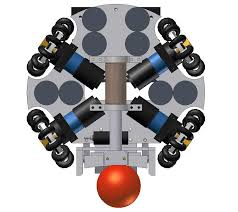

This system has _four_ individually controlled motors, which allows it to translate forwards and sideways _and_ rotate at the same time. A system with this capability (the ability to accelerate in any direction at any time) is called _fully-actuated_.

> Note: you may also hear this type of drive referred to as _holonomic_. This is a related property, although it is slightly more complex.

 - State: $(x, y)$ position, heading $\theta$, $x, y$ velocities, angular velocity $\omega$.
 - Inputs: $v_1, v_2, v_3, v_4$, the voltage given to each of the four wheel motors.
 - Outputs: wheel encoders (wheel velocities), gyroscope ($\omega$), overhead vision ($x, y, \theta$)

> Note: this system has _four_ inputs, but only _three_ velocity states. Think about why this is, and what constraints this might place on the inputs we give it. We have four wheel velocities but only three velocities in our state. What does this imply?

## Conventions
Throughout these documents, and in most control literature, we use the following notation:
 - State: $x \in \mathbb{R}^n$ (state $x$ is a vector with $n$ variables)
 - Input: $u \in \mathbb{R}^m$ (control input $u$ is a vector with $m$ variables)
 - Output: $y \in \mathbb{R}^l$ (sensor measurement $y$ is a vector with $l$ variables)

This means that we cannot use the variables $x$ and $y$ for coordinates in $\mathbb{R}^2$, such as for positions or velocities. We will instead use $p_x$ or $p_y$ for positions, and $v_x$ and $v_y$ for velocities.

## Exercise: Simulating a system
In this exercise, you will become familiar with running a simulation in Python. We use `scipy` and `numpy`, which provide us with some great utilities for linear algebra and scientific computing (including controls).

The code in the following cell sets up the code to simulate a generic system, and simulates a simple spring-mass-damper:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Mass_spring_damper.svg/1024px-Mass_spring_damper.svg.png" width="300" />

A spring-mass-damper consists of a spring rigidly attached to a immovable object (say, a wall) and a movable object with mass $m$. It also has a _damper_ which acts to slow down the motion of the spring system.

This system has two state variables: $x$ and $\frac{d}{dt}x$, also written $\dot x$.
In addition, you can apply a force $F$ to the object to influence its motion.
The output of the system ($y$) is the position - it's the same as one of the state variables, so we don't need to show both.

Don't worry too much about the math for now - we'll get into it in more detail later. For now, just get familiar with changing the system's parameters in the cell below to see how the system responds.

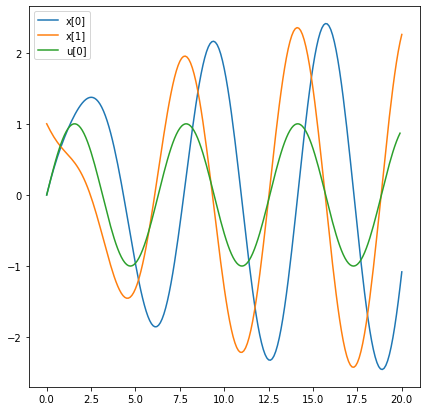

In [2]:
# Start with given [p, v]:
#  - x[0] = position
#  - x[1] = velocity
# CHANGEME: Try messing around with initial conditions!
x0 = np.array([0, 1])

# CHANGEME: Spring-mass-damper coefficients
m = 1
k = 1
d = 0.5

dynamics = lambda x, u, t: np.array([x[1], 1 / m * (u - k * x[0] - d * x[1])])
def dynamics(x, u, t):
    # Time derivatives of the system states
    return np.array([
        x[1],
        1 / m * (u[0] - k * x[0] - d * x[1])
    ])

# Simulate for 2 seconds
dt = 0.1
T = 200

def control_function(x, t):
    # CHANGEME: Control values as a function of x and t
    return np.sin(t)

# Simulate the system for 350 timesteps with 0.1 second steps.
rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    control_fn=control_function)

## Phase Plots
Often, in addition to simply graphing variables evolving over time on an axis, it can be helpful to graph the _phase space_, with one state variable on the x-axis and another state variable on the y-axis. Then, the system's dynamics can be represented by a vector field (an arrow at each point showing which direction a system at that state will move), and a particular run of the system can be represented as a path, following along the arrows in the field.

Run the next box to get an example of a phase plot. Note that our phase plot will show the dynamics of the system taking the control input into account, if one is passed into `simulate_system`.

Uncontrolled system (u = 0)


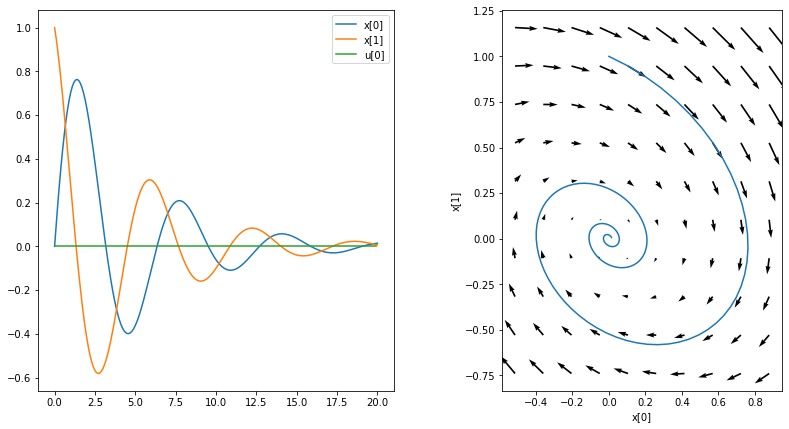

Controlled system (u=constant)


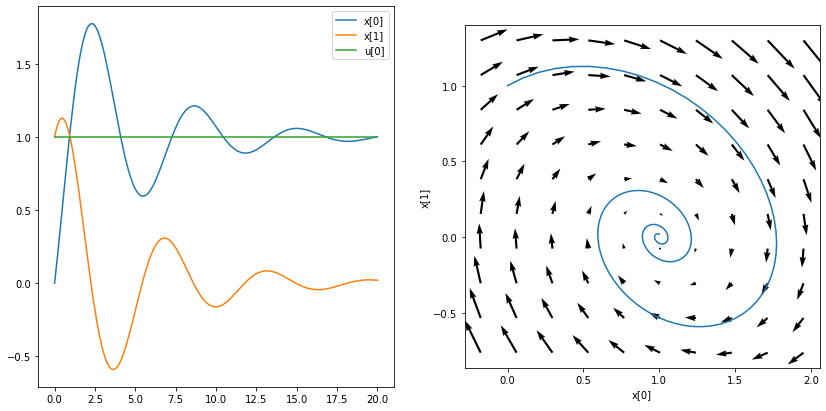

In [4]:
import importlib
importlib.reload(rjc)

x0 = np.array([0, 1])
dynamics = lambda x, u, t: np.array([x[1], u[0] - x[0] - 0.5 * x[1]])
dt = 0.1
T = 200

print("Uncontrolled system (u = 0)")
rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    plot_phase=(0, 1), control_fn=0.0)
print("Controlled system (u=constant)")
rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    plot_phase=(0, 1), control_fn=1.0)

## Part 2: Controllers and Feedback
As controls engineers, we need to understand the system we're working on. However, our end goal is to actually _control_ it, in order to make it do useful things. In other words, we want to find the value of $u$ that will make $x$ react in the way we want.

In principle, a controller is just a function that:
 - Takes in the current system output $y$
 - Outputs a control input $u$

In robotics, we will usually implement our controllers on a computer (or a microcontroller), which reads sensors ($y$), does computations, and outputs $u$ to our actuators.

That said: let's look at the simplest possible controller: no controller at all! We'll try to get a spining motorized wheel to match a particular speed using a constant control input.

Change the control input in the next cell until your system's final velocity $x[0]$ matches the goal $g[0]$.

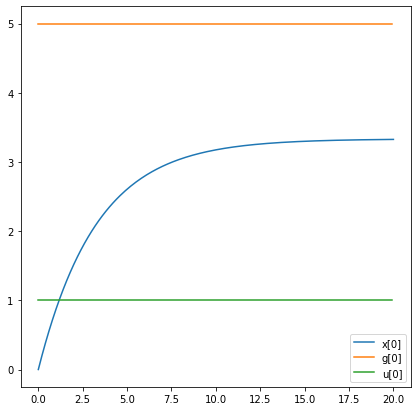

In [5]:
import importlib
importlib.reload(rjc)

# CHANGEME: Change this fixed control input until x[0] settles at g[0]
control = np.array([1])

x0 = np.array([0])
goal = np.array([5])
dynamics = lambda x, u, t: np.array([u[0] - 0.3 * x[0]])
dt = 0.1
T = 200
rjc.simulate_system(x0, dynamics, dt, T, discrete=False, control_fn=control, goal=goal)

This type of controller is called "feedforward". On its own, it isn't very useful. For example, what happens if the robot is running low on battery? Run the next cell to see what happens with the same controller on a slightly different system.

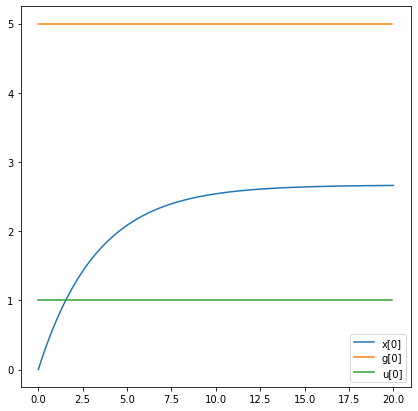

In [6]:
x0 = np.array([0])
goal = np.array([5])
dt = 0.1
T = 200
dynamics = lambda x, u, t: np.array([0.8 * u[0] - 0.3 * x[0]])
rjc.simulate_system(x0, dynamics, dt, T, discrete=False, control_fn=control, goal=goal)

A controller that breaks immediately in slightly different conditions isn't a useful controller at all! Instead, we'll need to look at the idea of _feedback_.

## Feedback and Bang-Bang Control
Right now, our controller is blindly outputting a predetermined value without regard to what the system should actually be doing. Instead, we want to look at the _response_ to a particular input, and adjust it accordingly. This principle is called feedback. Here's a block diagram illustrating the idea:
```
          +---------------------+          +----------------------+
          |                     |          |                      |
          |                     | Control  |                      |      Sensor
   Goal   |                     | Inputs   |                      |   Measurements
+-------->+     Controller      +--------->+        System        +---------+---------->
          |                     |          |                      |         |
          |                     |          |                      |         |
          |                     |          |                      |         |
          +----------+----------+          +----------------------+         |
                     ^                                                      |
                     |                                                      |
                     |                                                      |
                     |                                                      |
                     |                                                      |
                     |                      Feedback                        |
                     +-------------------------<----------------------------+
```

What does this mean in practice for the spinning wheel? Well, we'll want to compare our sensor measurements from feedback to our goal $g$. If the speed is too low, we'll want to give a higher control input to force it to go faster. If it's too high, we'll apply a smaller input to let it slow down.

> Note: Often, our sensor feedback measurements $y$ and state variables $x$ will coincide. For example, in this case, $x$ is velocity and $y$ is a measurement of velocity.
> Unless explicitly specified, for future examples we will assume that we have a perfect measurement of our state $x$ from our measurements. The design of _estimators_ - methods of calculating $x$ from imperfect sensor measurements - is an important part of control system design and will be discussed in later chapters.

Let's start with a simple scheme for determining our control inputs:
 - If the speed is too low, apply some "high" control input value $u_{hi}$.
 - If the speed is too high, apply some "low" control input value $u_{lo}$.

The simplest choices of $u_{lo}$ and $u_{hi}$ are the minimum and maximum values we are allowed to use in our actuators - for example, $u_{lo} = 0, u_{hi} = 5$. However, other values will also work.
 
Implement this control scheme in the next block.

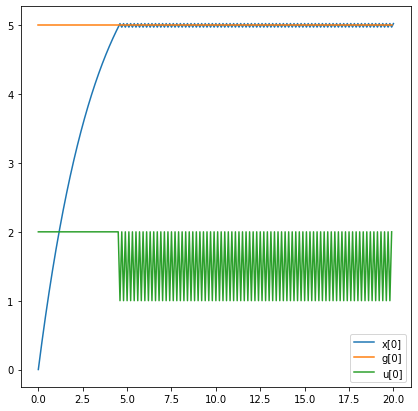

In [7]:
import importlib
importlib.reload(rjc)

def bang_bang_control(x, t, g):
    u_lo = 0
    u_hi = 5
    ######## CHANGEME: Implement bang-bang control ########
    u = 0
    #######################################################
    return u

x0 = np.array([0])
goal = np.array([5])
dt = 0.1
T = 200
dynamics = lambda x, u, t: np.array([u[0] - 0.3 * x[0]])

# Inputs kind of take over the plot. Separate them into two graphs.
rjc.simulate_system(x0, dynamics, dt, T, discrete=False, control_fn=bang_bang_control, goal=goal)

This actually works pretty well! It gets to the goal very quickly - much more quickly than the previous feed-forward (constant) controller. This is called "bang-bang control", and does actually have some nice theoretical properties. However, it does have some drawbacks.

First off, it is _very_ aggressive: it jumps back and forth between the maximum and minimum control inputs. In simulation this may be fine, but in the real world this can put a lot of mechanical stress on the system. In the end, this can result in broken mechanical systems among other issues.

Next, let's look at what happens when we try to apply it to a different system - specifically, a mass-damper (like the spring-mass-damper, but with $k=0$). Recall that it this type of system has two state variables: position and velocity. That will become important very soon.

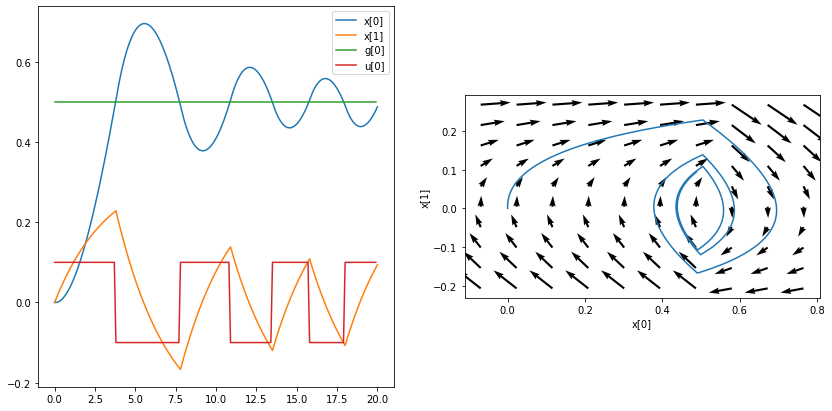

In [8]:
x0 = np.array([0, 0])
dynamics = lambda x, u, t: np.array([x[1], u[0] - 0.3 * x[1]])
dt = 0.1
T = 200

def bang_bang_control_2d(x, t, g):
    # Just like the one from earlier.
    err = x[0] - g
    if err < 0:
        return 0.1
    else:
        return -0.1

rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    control_fn=bang_bang_control_2d, goal=0.5, plot_phase=True)

Clearly, this isn't ideal. It's just going to keep **oscillating** (moving back and forth) at a set frequency around the goal point forever. Why does this happen?

The short answer is that the box has _inertia_. This means that the variable that we care about - position - will not respond instantaneously to a change in the input. If you apply an abrupt change in force, it will instantly begin to change the velocity, but the position's response only changes as the velocity changes (and so it will not change abruptly).

>Mathematically, this can be explained as follows: the variable we care about (position) must be differentiated _twice_ to explicitly find the control input. Remember $F=ma$ from physics? We can use the same language to describe the box's motion. Let $p$ be position, $v$ be velocity, and $a$ be acceleration:
$$F = ma = u - c\dot{p}$$
$$a = \frac{1}{m}(u - cv)$$
>If we have constant $u$, we have to integrate _twice_ to directly see a corresponding change in $x$. Therefore, the best we can get is a second-order (quadratic) response to a step up in control input.

In general, bang-bang will only work well for "first-order" systems, when the input directly controls the derivative of the state variable.

## Proportional Control
How can we fix these problems with bang-bang? Well, clearly the issue is expecting the states and outputs to change as quickly as we can change our control input. To fix this, let's change our control input _gradually_ instead of all at once. In other words, we want to decrease the magnitude of our control input as we get closer to our goal. Let's make this clear by defining the _error_ $e$ to be the difference between the goal and (a single part of) the state:
$$e = g - x_0$$

> Note: for now, when we say "goal" we are talking about a _single_ state variable, not the entire state vector. That means that it only corresponds to _one_ of the variables in the state. In the case of the block, our goal is just the position - we want all other variables to be equal to zero.

As you can probably tell by the section header, we can accomplish our goals by making our control signal proportional to our error. Let's pick some constant $k_p$, and use this to calculate our control signal.

$$u = k_pe$$

As you can see, a higher $k_p$ will make our controller more aggressive. However, for a fixed $k_p$ the controller and system together will:
 - Respond very aggressively with negative $u$ when $x$ is much larger than $g$
 - Respond with small adjustments in either direction when $x$ is close to $g$ ($e$ is small)
 - Respond very aggressively with positive $u$ when $x$ is much smaller than $g$
Let's implement this in a simulation, on the same block mechanism.

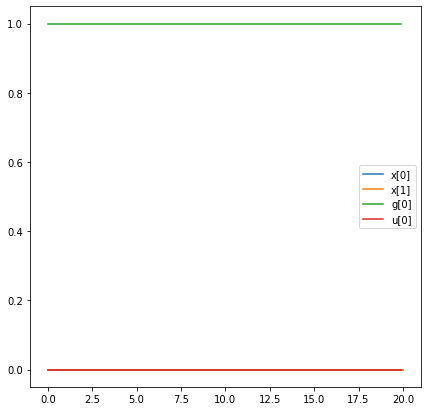

In [9]:
### import importlib
importlib.reload(rjc)

x0 = np.array([0, 0])
dynamics = lambda x, u, t: np.array([x[1], u[0] - 0.5 * x[1]])
dt = 0.1
T = 200

# CHANGEME: Modify kp to see the new response
# Try values: 0.1, 0.5, 5.0, 10.0
kp = 0
def proportional_control(x, t, g):
    return kp * (g - x[0])

rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    control_fn=proportional_control, goal=1.0)

## Overshoot and Underdamped Systems
You'll notice that the results from the previous exercise were pretty bad. For pretty much any value of $k_p$, we either saw:
 - The system was slow to converge. That is, it took a good portion of the 20-second period - or maybe all of it - to get anywhere near the goal. We want our systems to converge to the goal quickly.
 - The system overshot the goal and oscillated back and forth for a little while after passing the goal. This isn't _necessarily_ a bad thing - but when it's too large it can be problematic (what if we had a stack of delicate items at position 1.5?), and usually we care about the time before the system settles (both position and velocity are where we want them to be).
 
In some cases, both of the above problems occurred to varying degrees - but just by changing $k_p$, we weren't able to get rid of them.

The system that you just simulated is called "underdamped". Remember the first exercise, where you played with the $c$ constant to give the mass-spring-damper different responses? The higher that constant is, the higher the _damping_. High values of $c$ will slow down a fast-moving system to a rapid halt, while small values will cause it to change more gradually.

To jog your memory, let's run some simulations with different values of $c$.

In [ ]:
x0 = np.array([1, 0])

print("c = 0.5")
dynamics = lambda x, u, t: np.array([x[1], u[0] - x[0] - 0.5 * x[1]])
rjc.simulate_system(x0, dynamics, dt, T, discrete=False, plot_phase=True)

print("c = 1.5")
dynamics = lambda x, u, t: np.array([x[1], u[0] - x[0] - 1.5 * x[1]])
rjc.simulate_system(x0, dynamics, dt, T, discrete=False, plot_phase=True)

print("c = 5")
dynamics = lambda x, u, t: np.array([x[1], u[0] - x[0] - 5 * x[1]])
rjc.simulate_system(x0, dynamics, dt, T, discrete=False, plot_phase=True)

As you can see, larger damping values will decrease oscillations. The phase plots should give you even more intuition: oscillations show up as spirals, while excessive damping "forces" the system toward moving along a particular line in phase space, which reduces the amount it spirals. We'll learn more about this later.

## Proportional-Derivative Control
An appropriate damping value should fix the problems we saw in the proportional controller! But how can we do this?

Well, there are two approaches:
 1. Hardware damping: very nicely ask mechanical to physically add some sort of dampener to the system
 2. Software/controls damping: simulate a damping force in our controller
 
Usually, option 2 is much better than option 1, for many reasons:
 - Finding an object to act as a mechanical damper is difficult (especially if you want to find a nice linear damper, like we described above) and possibly expensive.
 - We like to change out constants all of the time. It's a lot easier to change the parameters of your control loop than it is to change the physical system.
 - A mechanical damper is a waste of energy. Every time you actually _want_ to be moving fast, it's going to try to oppose the direction of motion and slow you down.
 
So, how do we create a damper in code? We want to create a linear force proportional to the velocity (or rather, the rate of change of the error). Let's just add this in to our existing proportional control law:
$$u = k_pe + k_d\frac{de}{dt}$$
We've named the corresponding constant $k_d$, for _derivative_ constant, for obvious reasons.

In the real world, we can't actually take the derivative of our sensor readings: our microcontroller runs at a set frequency, and there's no way to get readings any faster than that. Instead, we need to use _finite differences_. Recall the definition of the derivative:
$$\frac{de}{dt} = \lim_{h \to 0}\frac{e(t+h) - e(t)}{h}$$
We can approximate this by fixing $h$ (our delta-time) and calculating the average rate-of-change over the past time period. Implement this in the next cell, and use it to build a proportional-derivative controller.

In [ ]:
### import importlib
importlib.reload(rjc)

x0 = np.array([0, 1])
dynamics = lambda x, u, t: np.array([x[1], u[0] - 0.5 * x[1]])
T = 200

# CHANGEME: Modify PD constants to see the new response
kp = 0.5
kd = 0.5

# Hint: you will need to use this value (delta-time)
dt = 0.1

# Hint: you will need to set this value in the controller
last_e = 0.0

def pd_control(x, t, g):
    global last_e
    
    error = g - x[0]
    
    u = 0
    ######## CHANGEME: Implement a PD controller! ########
    # Hint: use error, last_e, dt, kp, and kd
    # Hint: Don't forget to set last_e after you're done
    ######################################################
    
    return u

rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    control_fn=pd_control, goal=1.0, plot_phase=True)

Examine the following definition:
> At a **fixed point** in state space, a system given zero control input $u$ will maintain the same state.

To test your understanding so far, answer the following questions:

1. In the damped block system described above, what are the fixed points? (Remember that $x$ includes both position and velocity)
2. What about the spring-mass-damper system? What are the fixed points here? (Again, specify both position and velocity)
3. What will happen when we use a PD controller on a system where the goal is not a fixed point?
    - _Hint: think about what the calculated value of $u$ would be at that point_

After you've thought about all three questions, move on to the next cell to run a simulation to get an answer to the last question.

In [ ]:
kp = 0.5
kd = 0.5

dynamics = lambda x, u, t: np.array([x[1], u[0] - 0.1 * x[0] - 0.5 * x[1]])
rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    control_fn=pd_control, goal=1.0, plot_phase=True)

It wasn't able to get to the target! All of this math, but at the end of the day we are back where we started with feedforward control.

We call this type of error - the error that remains after everything has settled down and the system is no longer moving - "steady-state error", and any good controller should 

## Proportional-Integral-Derivative (PID) Control
Imagine you have a system that has a small steady-state error for a long period of time. Intuitively, you want to ramp up your control input higher and higher the longer you remain at that small error. Effectively, the controller should accumulate past errors and use them to influence the control signal.

We can do this by taking the integral of the past error values and adding it to our control signal. This modifies our control law:
$$u = k_pe + k_i\int_{0}^tedt + k_d\frac{de}{dt}$$
Just like with the derivative term, we can't actually calculate our integral directly. Instead, we have to use the definition of the integral. Recall:
$$\int^bf(x)dx = \lim_{h \to 0}\sum_{i=0}^N f(a+ih)h$$
In exactly the same way, by fixing our step size $h$, we can calculate an approximation for the integral of our error.

In the next block, you'll implement this concept. Then, you will have a full PID controller!

> Note: the integral controller adds a "history" to the controller, so past events need to be taken into account to predict future values. This has a few interesting effects:
 - It effectively increases the number of state variables you need to describe the system - i.e., it turns our mass-spring-damper problem into a 3-dimensional system with $(p, v, i)$ where $i$ is the integrated error over time.
 - Phase plots (specifically, the vector fields) don't tell the entire story anymore: your controller depends on an extra dimension that isn't in the plot.

We'll avoid using phase plots from now on for this reason.

In [ ]:
### import importlib
importlib.reload(rjc)

x0 = np.array([0, 0])
dynamics = lambda x, u, t: np.array([x[1], u[0] - 0.1 * x[0] - 0.5 * x[1]])
T = 200

# CHANGEME: Modify PID constants to see the new response
kp = 0.5
ki = 0.05
kd = 0.5

# Hint: you will need to use this value (delta-time)
dt = 0.1

# Hint: you will need to set these values in the controller
last_e = 0.0
integral = 0.0

def pid_control(x, t, g):
    global last_e, integral
    
    u = 0.0
    
    ######## CHANGEME: Implement a PID controller! ########
    # Hint: you'll need to update both last_e and integral
    
    #######################################################
    
    return u

rjc.simulate_system(x0, dynamics, dt, T, discrete=False,
                    control_fn=pid_control, goal=1.0)

# Section 3: Real-World Constraints
So far, we've assumed that we can give any value of $u$ that we want. This goes fine in simulation - but once we're in the real world, it's impossible. We can't give 1,000,000 volts to a motor - even if we command it, it will still be capped out at some maximum value.

In practice, the simplest way to deal with these limits has two parts:
 1. "Clip" your control signal at some maximum value, usually dicted by the hardware. For instance, you can't use a 12V power supply to drive a motor at any higher than 12 volts.
 2. Tune your controllers (select $k_p$, $k_i$, $k_d$) so that the control input doesn't go too far above the maximum value
 
When this clipping is in effect to a large degree - i.e., when your PID controller is commanding very large values, you will get a drastically different response than you would expect with an un-clipped controller. An example is in the next cell.

In [ ]:
importlib.reload(rjc)
x0 = np.array([-1.3, -1.189])

T = 300

kp = 1.0
ki = 0.2
kd = 1.5

# Use functions from RJC to do PID for us, for now
controller = rjc.PID(kp, ki, kd, dt)
controller(x0, 0, 0.8)
rjc.simulate_system(x0, rjc.mass_spring_damper(1.0, -0.2, 0.1), dt, T, discrete=False,
                    control_fn=rjc.limit_control(controller, -3, 3), goal=0.8)

controller = rjc.PID(kp, ki, kd, dt)
controller(x0, 0, 0.8)
rjc.simulate_system(x0, rjc.mass_spring_damper(1.0, -0.2, 0.1), dt, T, discrete=False,
                    control_fn=rjc.limit_control(controller, -1, 1), goal=0.8)

These two PID controllers had identical parameters, but were run on systems limited to different values: $[-3, 3]$ for the first one and $[-1, 1]$ for the second. Because the second controller was always running into control limits, the system's dynamics were entirely different - and it experienced wildly different behaviors.

Note that this is just the case for the particular set of gains in the example above. There will likely be _some_ set of PID constants that is able to control both systems effectively - but there are many more that will fail on the second one.

> Exercise: find a set of gains $k_p$, $k_i$, and $k_d$ that give good results for both systems.

# Section 4: Practice Makes Perfect
Now we know how to describe a particular type of controller: the PID controller. However, actually applying this to a real system is a difficult task.

This difficulty lies in the three unknowns: $k_p$, $k_i$, and $k_d$. Each of these parameters (called "gains") must be individually selected in order to tune a control loop. However, there is no universal formula for tuning them - instead, you need to be able to intuitively grasp what each one does. There are, however, some heuristics to get you started.

To recap what we've said so far:
 - $k_p$ makes the controller more aggressive to respond to step disturbances (like commanding an instantaneous move-to-goal)
 - $k_d$ prevents the controller from overshooting and dampens its response
 - $k_i$ prevents the controller from having steady-state error, but can increase overshoot

Together, you will need to tune these three values to find useful responses.

To give you some practice, we've set up five possible scenarios with different systems and different coefficients. These scenarios are similar to what you might find in real-world systems. And, all you'll get is the time-series data from the most recent run - no phase plots this time.

## Spinning Wheel Velocity Control
This is a super simple system. Intuitively, all you need to know is that you have a target velocity, and that a spinning wheel on a motor will experience a force proportional to its speed but in the opposite direction.

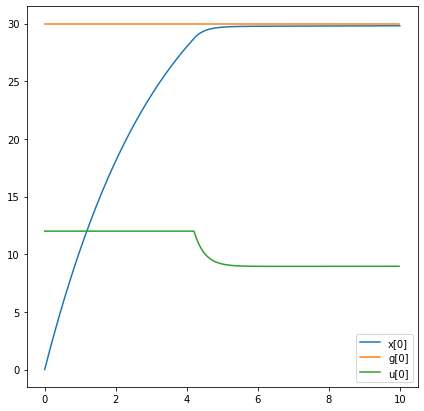

In [65]:
kp = 3
ki = 0.15
kd = 0.0

spinner_system = rjc.first_order_velocity(1, 0.3)
spinner_controller = rjc.PID(kp, ki, kd, dt)

dt = 0.02
x0 = np.array([0.0])
rjc.simulate_system(x0, spinner_system, dt, 500, discrete=False,
                    control_fn=rjc.limit_control(spinner_controller, -12, 12), goal=30.0)


## Linear Mechanism Control
This system is a simple linear mechanism. The motor spins a pulley, which is used to move an object fixed to a belt in a linear fashion. You are given the position and velocity of the object (in meters).
![mechanism](https://www.orientalmotor.com/images/motor-sizing/EntryBeltActuator01.jpg)

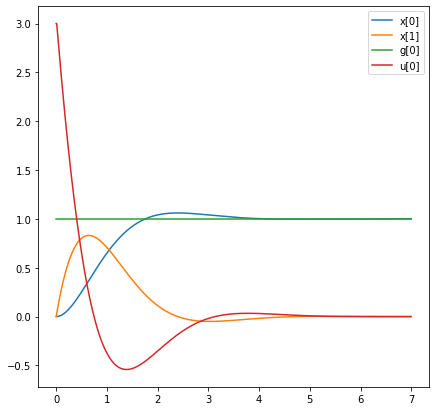

In [121]:
kp = 3
ki = 0.0
kd = 2

linear_system = rjc.mass_spring_damper(1, 0.0, 0.3)
linear_controller = rjc.PID(kp, ki, kd, dt)

x0 = np.array([0.0, 0.0])
dt = 0.01
rjc.simulate_system(x0, linear_system, dt, 700, discrete=False,
                    control_fn=rjc.limit_control(linear_controller, -3, 3), goal=1.0)

## Drivetrain Angle Control
The next problem deals with controlling the angle of a differential drivetrain that is able to turn in place. This is a bit more challenging than regular position control: **static friction** will play a large part in the system's dynamics. This is a very difficult effect to work with, especially when trying to accurately perform small motions.

While the drivetrain is stationary, static friction will apply up to a small amount of force to counteract any control inputs you provide. Inside of this range, there will be no acceleration. Once you are out of this range, the force applied will decrease sharply (sliding friction is much less than static friction). This creates a _discontinuity_ in the system, which makes it very difficult to control.

![skid_steer](https://courses.jamesmpoe.com/robotics/images/9/97/Drivetrain_skid_steer.jpg)

Input: torque applied to the left and right drivetrain wheels (in opposite directions), from -3 to 3.
Output: angle x[0] in radians.

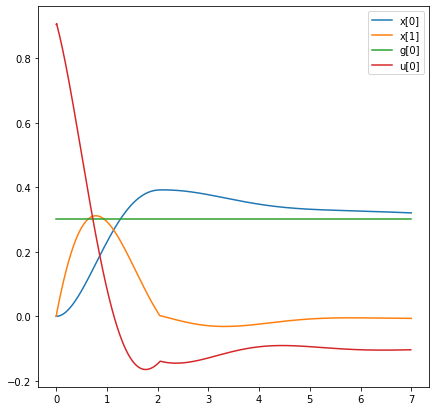

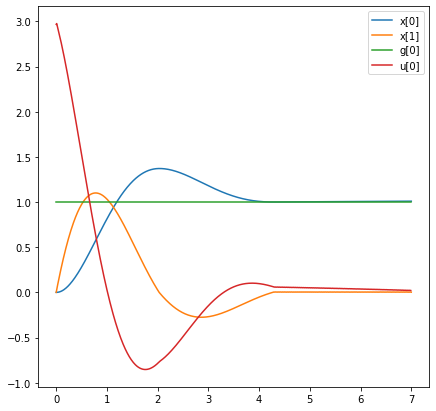

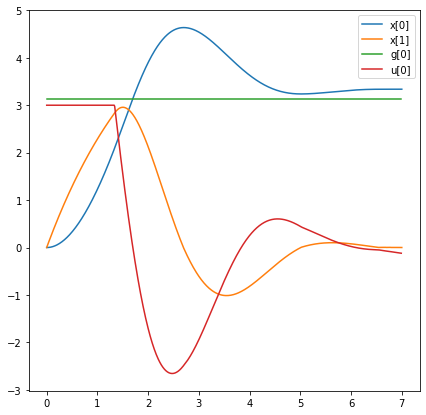

In [113]:
kp = 3
ki = 0.8
kd = 1

def angle_system(x, u, t):
    force = u[0] - 0.5 * x[1]
    
    if x[1] > 3e-3:
        force -= 0.1
    elif x[1] < 3e-3:
        force += 0.1
    else:
        if force > 0:
            force = max(0, force - 0.2)
        else:
            force = min(0, force + 0.2)
    
    return np.array([x[1], force])

angle_controller = rjc.PID(kp, ki, kd, dt)

x0 = np.array([0.0, 0.0])
dt = 0.01
rjc.simulate_system(x0, angle_system, dt, 700, discrete=False,
                    control_fn=rjc.limit_control(angle_controller, -3, 3), goal=0.3)
rjc.simulate_system(x0, angle_system, dt, 700, discrete=False,
                    control_fn=rjc.limit_control(angle_controller, -3, 3), goal=1.0)
rjc.simulate_system(x0, angle_system, dt, 700, discrete=False,
                    control_fn=rjc.limit_control(angle_controller, -3, 3), goal=np.pi)


## Inverted Pendulum Control
![invpend](https://math-sciences.org/wp-content/uploads/2016/03/InvertedPendulum.jpg)
This system is not very "well-behaved". The other systems we've seen will at least have somewhat consistent forces applied in different states, but this will operate entirely differently if it's upright (unstable) compared to in the hanging position (stable).

We'll learn a lot more about this type of system later on, and formalize what we mean by "well-behaved". Luckily, it's pretty consistent within a small distance of the upright position. Try and stabilize it around that.

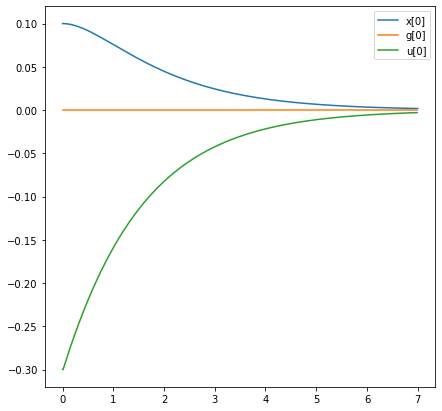

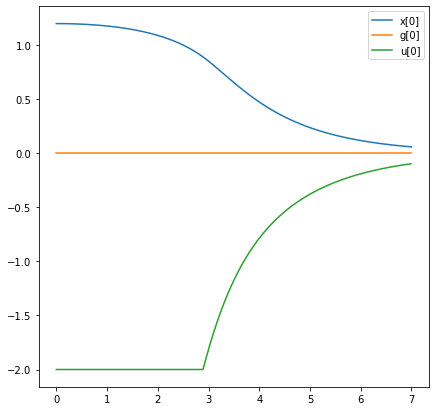

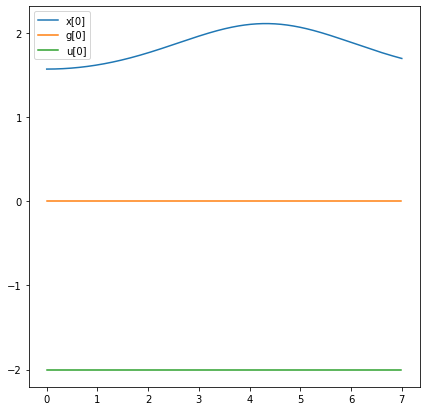

In [159]:
kp = 3
ki = 0.0
kd = 2

def angle_system(x, u, t):
    return np.array([x[1], u[0] + 2.1 * np.sin(x[0])])

angle_controller = rjc.PID(kp, ki, kd, dt)

dt = 0.01
rjc.simulate_system(np.array([0.1, 0.0]), angle_system, dt, 700, discrete=False,
                    control_fn=rjc.limit_control(angle_controller, -2, 2), goal=0.0, hide_states=[1])
rjc.simulate_system(np.array([1.2, 0.0]), angle_system, dt, 700, discrete=False,
                    control_fn=rjc.limit_control(angle_controller, -2, 2), goal=0.0, hide_states=[1])
rjc.simulate_system(np.array([np.pi/2, 0.0]), angle_system, dt, 700, discrete=False,
                    control_fn=rjc.limit_control(angle_controller, -2, 2), goal=0.0, hide_states=[1])